# Frozen Lake

In [1]:
import gymnasium as gym

env = gym.make("FrozenLake-v1", desc=None, map_name="4x4", is_slippery=False, render_mode="rgb_array")
print(env.observation_space)
print(env.action_space)

Discrete(16)
Discrete(4)


In [2]:
import numpy as np

# Create q-table. 16 possible states, 4 actions for each state. 16x4 matrix.
def init_q_table(state_space: int, action_space: int) -> np.ndarray:
    """Initialize the q-table with shape (state_space, action_space)."""
    q_table = np.zeros((state_space, action_space))
    return q_table

q_table = init_q_table(env.observation_space.n, env.action_space.n)
q_table.shape

(16, 4)

In [3]:
import random

def greedy_policy(q_table: np.ndarray, state: int) -> int:
    """Select the action that maximizes the reward, starting from the given state."""
    return q_table[state].argmax()

def epsilon_greedy_policy(q_table: np.ndarray, state: int, epsilon: float) -> int:
    """
    Select a random action with probability epsilon, and the greedy action with
    probability 1 - epsilon. When epsilon is high, explore more, and when epsilon is low,
    exploit more.
    """
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        return greedy_policy(q_table, state)

In [4]:
from dataclasses import dataclass

@dataclass
class HyperParams:
    # Train params.
    n_train_episodes = 10_000
    learning_rate = 0.7

    # Eval params.
    n_eval_episodes = 100

    # Env params.
    env_id = "FrozenLake-v1"
    max_steps = 99
    gamma = 0.95

    # Exploration params
    max_epsilon = 1.0
    min_epsilon = 0.05
    decay_rate = 0.0005

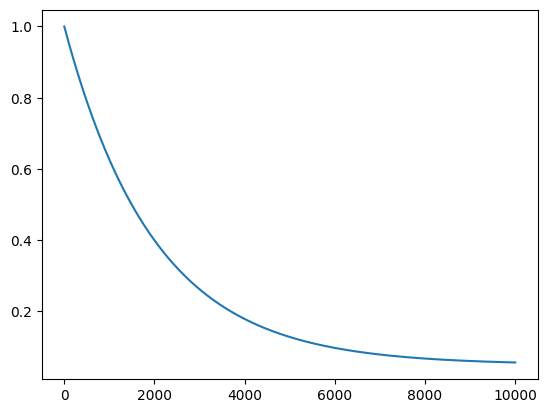

In [5]:
import matplotlib.pyplot as plt

def get_epsilon(episode: int, hyper_params: HyperParams) -> float:
    """Get the exponentially decayed epsilon value based on the episode."""
    decay = np.exp(-1 * hyper_params.decay_rate * episode)  # Decays e^-x.

    # Only decay difference to keep epsilon above 0.
    decayable_epsilon = hyper_params.max_epsilon - hyper_params.min_epsilon
    return hyper_params.min_epsilon + (decayable_epsilon * decay)

episodes = np.arange(HyperParams.n_train_episodes)
epsilons = get_epsilon(episodes, HyperParams)

plt.plot(episodes, epsilons)

In [6]:
def train(q_table: np.ndarray, env: gym.Env, hyper_params: HyperParams) -> np.ndarray:
    """Train the q_table and return the updated q_table."""
    for episode in range(hyper_params.n_train_episodes):
        # Decay epsilon based on episode.
        epsilon = get_epsilon(episode, hyper_params)
        state, info = env.reset()

        for step in range(hyper_params.max_steps):
            # Take action and recieve observation.
            action = epsilon_greedy_policy(q_table, state, epsilon)
            new_state, reward, terminated, truncated, info = env.step(action)

            # Update q-table using TD.
            value_estimate = reward + (hyper_params.gamma * q_table[new_state].max())
            q_table[state, action] += hyper_params.learning_rate * (value_estimate - q_table[state, action])

            # Start a new episode.
            if terminated or truncated:
                break
            
            # Update the state tracker. Onwards!
            state = new_state

    return q_table

q_table = train(q_table, env, HyperParams)
print(q_table)

[[0.73509189 0.77378094 0.77378094 0.73509189]
 [0.73509189 0.         0.81450625 0.77378094]
 [0.77378094 0.857375   0.77378094 0.81450625]
 [0.81450625 0.         0.77378094 0.77378094]
 [0.77378094 0.81450625 0.         0.73509189]
 [0.         0.         0.         0.        ]
 [0.         0.9025     0.         0.81450625]
 [0.         0.         0.         0.        ]
 [0.81450625 0.         0.857375   0.77378094]
 [0.81450625 0.9025     0.9025     0.        ]
 [0.857375   0.95       0.         0.857375  ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.9025     0.95       0.857375  ]
 [0.9025     0.95       1.         0.9025    ]
 [0.         0.         0.         0.        ]]


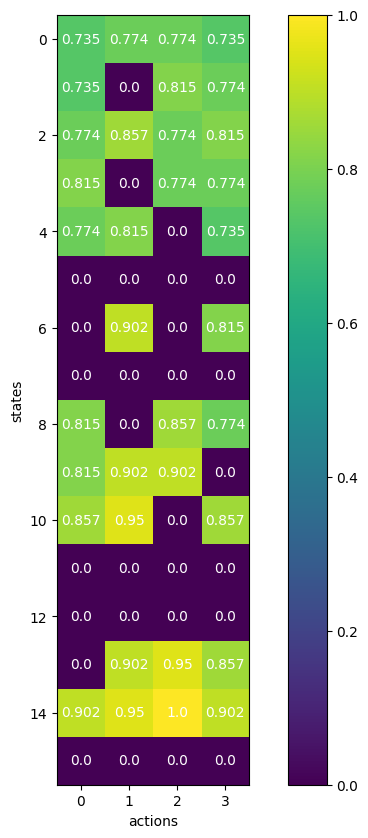

In [7]:
def display_q_table(q_table) -> plt.Figure:
    """Display the q_table as a heatmap."""
    fig, ax = plt.subplots(figsize=(10, 10))

    img = ax.imshow(q_table)
    fig.colorbar(img)

    ax.set_xlabel("actions")
    ax.set_ylabel("states")

    for i in range(q_table.shape[0]):
        for j in range(q_table.shape[1]):
            text = ax.text(
                j, i,
                s=round(q_table[i, j], 3),
                ha="center", va="center", color="w"
            )
        
    return fig

display_q_table(q_table);

In [8]:
def eval_agent(q_table: np.ndarray, env: gym.Env, hyper_params: HyperParams) -> tuple[float, float]:
    """Evaluate the agent, returning the mean and standard deviation of the rewards."""
    episode_rewards = []
    for episode in range(hyper_params.n_eval_episodes):
        total_reward = 0

        # Reset environment and get initial state.
        state, info = env.reset()
        
        for step in range(hyper_params.max_steps):
            # Inference: use greedy policy to get action.
            action = greedy_policy(q_table, state)

            # Take action and get reward and new state.
            new_state, reward, terminated, truncated, info = env.step(action)

            # Add reward to total reward.
            total_reward += reward
            
            if terminated or truncated:
                break

            # Move to new state.
            state = new_state

        episode_rewards.append(total_reward)

    return np.mean(episode_rewards), np.std(episode_rewards)

eval_agent(q_table, env, HyperParams)

(np.float64(1.0), np.float64(0.0))

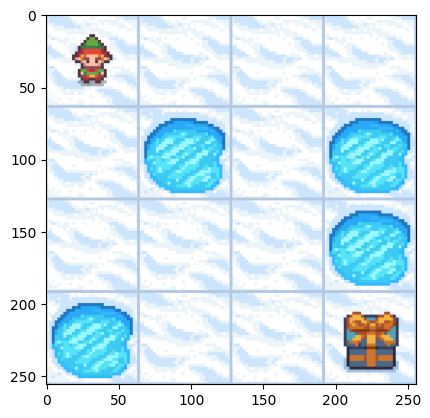

In [9]:
import matplotlib.animation as mpl_ani
from IPython.display import HTML

def get_frames(q_table: np.ndarray, env: gym.Env) -> list[np.ndarray]:
    """Play a single episode and return all frames."""
    state, info = env.reset()

    frames = [env.render()]

    while True:
        action = greedy_policy(q_table, state)
        new_state, reward, terminated, truncated, info = env.step(action)

        frames.append(env.render())
        if terminated or truncated:
            break
        state = new_state

    env.close()
    return frames

def show_episode(q_table: np.ndarray, env: gym.Env) -> mpl_ani.FuncAnimation:
    """Show the agent going through a single episode."""
    frames = get_frames(q_table, env)

    fig, ax = plt.subplots()
    img = ax.imshow(frames[0])

    def update(frame: int):
        """Update the image."""
        img.set_data(frames[frame])
        return img
    
    ani = mpl_ani.FuncAnimation(fig=fig, func=update, frames=len(frames))
    return ani

ani = show_episode(q_table, env)
HTML(ani.to_jshtml())